### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [1]:
################## 1. Download checkpoints and build models
import os
if os.path.exists('/content/VAR'): os.chdir('/content/VAR')
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  # disable default parameter init for faster speed
from models import VQVAE, build_vae_var

# we recommend using imagenet-512-d36 model to do the in-painting & out-painting & class-condition editing task
MODEL_DEPTH = 36    # TODO: =====> please specify MODEL_DEPTH <=====

assert MODEL_DEPTH in {16, 20, 24, 30, 36}


# download checkpoint
# hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = './model_path/var/vae_ch160v4096z32.pth', f'./model_path/var/var_d{MODEL_DEPTH}.pth'
# if not osp.exists(vae_ckpt): os.system(f'wget {hf_home}/{vae_ckpt}')
# if not osp.exists(var_ckpt): os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
FOR_512_px = MODEL_DEPTH == 36
if FOR_512_px:
    patch_nums = (1, 2, 3, 4, 6, 9, 13, 18, 24, 32)
else:
    patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px,
)

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'preparation finished.')

d:\anaconda3\envs\var\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



[constructor]  ==== flash_if_available=True (0/36), fused_if_available=True (fusing_add_ln=0/36, fusing_mlp=0/36) ==== 
    [VAR config ] embed_dim=2304, num_heads=36, depth=36, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.15 (tensor([0.0000, 0.0043, 0.0086, 0.0129, 0.0171, 0.0214, 0.0257, 0.0300, 0.0343,
        0.0386, 0.0429, 0.0471, 0.0514, 0.0557, 0.0600, 0.0643, 0.0686, 0.0729,
        0.0771, 0.0814, 0.0857, 0.0900, 0.0943, 0.0986, 0.1029, 0.1071, 0.1114,
        0.1157, 0.1200, 0.1243, 0.1286, 0.1329, 0.1371, 0.1414, 0.1457, 0.1500]))

[init_weights] VAR with init_std=0.0120281
preparation finished.


In [13]:
################## 2. Define some helper functions for zero-shot editing

from typing import List, Optional, Union

import torch
import torch.nn.functional as F
from models.var import AdaLNSelfAttn, sample_with_top_k_top_p_, gumbel_softmax_with_rng


def get_edit_mask(patch_nums: List[int], y0: float, x0: float, y1: float, x1: float, device, inpainting: bool = True) -> torch.Tensor:
    ph, pw = patch_nums[-1], patch_nums[-1]
    edit_mask = torch.zeros(ph, pw, device=device)
    edit_mask[round(y0 * ph):round(y1 * ph), round(x0 * pw):round(x1 * pw)] = 1 # outpainting mode: center would be gt
    if inpainting:
        edit_mask = 1 - edit_mask   # inpainting mode: center would be model pred
    return edit_mask    # a binary mask, 1 for keeping the tokens of the image to be edited; 0 for generating new tokens (by VAR)


# overwrite the function of 'VAR::autoregressive_infer_cfg'
def autoregressive_infer_cfg_with_mask(
    self, B: int, label_B: Optional[Union[int, torch.LongTensor]],
    g_seed: Optional[int] = None, cfg=1.5, top_k=0, top_p=0.0,
    more_smooth=False,
    input_img_tokens: Optional[List[torch.Tensor]] = None, edit_mask: Optional[torch.Tensor] = None,
) -> torch.Tensor:   # returns reconstructed image (B, 3, H, W) in [0, 1]
    """
    only used for inference, on autoregressive mode
    :param B: batch size
    :param label_B: imagenet label; if None, randomly sampled
    :param g_seed: random seed
    :param cfg: classifier-free guidance ratio
    :param top_k: top-k sampling
    :param top_p: top-p sampling
    :param more_smooth: smoothing the pred using gumbel softmax; only used in visualization, not used in FID/IS benchmarking
    :param input_img_tokens: (optional, only for zero-shot edit tasks) tokens of the image to be edited
    :param edit_mask: (optional, only for zero-shot edit tasks) binary mask, 1 for keeping given tokens; 0 for generating new tokens
    :return: if returns_vemb: list of embedding h_BChw := vae_embed(idx_Bl), else: list of idx_Bl
    """
    # set up the random seed
    if g_seed is None: rng = None
    else: self.rng.manual_seed(g_seed); rng = self.rng

    # prepare class labels
    if label_B is None:
        label_B = torch.multinomial(self.uniform_prob, num_samples=B, replacement=True, generator=rng).reshape(B)
    elif isinstance(label_B, int):
        label_B = torch.full((B,), fill_value=self.num_classes if label_B < 0 else label_B, device=self.lvl_1L.device)
    
    # create the class embedding for both the conditional and the unconditional cases
    sos = cond_BD = self.class_emb(torch.cat((label_B, torch.full_like(label_B, fill_value=self.num_classes)), dim=0))

    # generate the positional embedding and initialize the first token map
    lvl_pos = self.lvl_embed(self.lvl_1L) + self.pos_1LC
    next_token_map = sos.unsqueeze(1).expand(2 * B, self.first_l, -1) + self.pos_start.expand(2 * B, self.first_l, -1) + lvl_pos[:, :self.first_l]

    # initialize empty output feature map    
    cur_L = 0
    f_hat = sos.new_zeros(B, self.Cvae, self.patch_nums[-1], self.patch_nums[-1])

    # enable kv caching
    for b in self.blocks: b.attn.kv_caching(True)

    # loop through each patch resoloution level and generate content
    for si, pn in enumerate(self.patch_nums):   # si: i-th segment
        ratio = si / self.num_stages_minus_1
        # last_L = cur_L
        cur_L += pn*pn

        # get conditionally modulated input (via AdaLN)
        # assert self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].sum() == 0, f'AR with {(self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L] != 0).sum()} / {self.attn_bias_for_masking[:, :, last_L:cur_L, :cur_L].numel()} mask item'
        cond_BD_or_gss = self.shared_ada_lin(cond_BD)
        x = next_token_map
        AdaLNSelfAttn.forward

        # forward pass through the transformer blocks
        for b in self.blocks:
            x = b(x=x, cond_BD=cond_BD_or_gss, attn_bias=None)

        # get logits for current token prediction
        logits_BlV = self.get_logits(x, cond_BD)

        # apply classifier-free guidance
        t = cfg * ratio
        logits_BlV = (1+t) * logits_BlV[:B] - t * logits_BlV[B:]
        
        # sampl discrete tokens from the logits
        idx_Bl = sample_with_top_k_top_p_(logits_BlV, rng=rng, top_k=top_k, top_p=top_p, num_samples=1)[:, :, 0]

        # convert token indices to embeddings
        if not more_smooth: # this is the default case
            h_BChw = self.vae_quant_proxy[0].embedding(idx_Bl)   # B, l, Cvae
        else:   # not used when evaluating FID/IS/Precision/Recall
            gum_t = max(0.27 * (1 - ratio * 0.95), 0.005)   # refer to mask-git
            h_BChw = gumbel_softmax_with_rng(logits_BlV.mul(1 + ratio), tau=gum_t, hard=False, dim=-1, rng=rng) @ self.vae_quant_proxy[0].embedding.weight.unsqueeze(0)

        # reshape to image feature map layout
        h_BChw = h_BChw.transpose_(1, 2).reshape(B, self.Cvae, pn, pn)

        # if edit_mask is provided, replace the generated tokens with the given tokens
        if edit_mask is not None:
            current_mask = edit_mask[si]
            gt_BChw = self.vae_quant_proxy[0].embedding(input_img_tokens[si]).transpose_(1, 2).reshape(B, self.Cvae, pn, pn)
            h_BChw = replace_embedding(current_mask, h_BChw, gt_BChw, pn, pn)

        # prepare token map for next stage
        f_hat, next_token_map = self.vae_quant_proxy[0].get_next_autoregressive_input(si, len(self.patch_nums), f_hat, h_BChw)
        if si != self.num_stages_minus_1:   # prepare for next stage
            next_token_map = next_token_map.view(B, self.Cvae, -1).transpose(1, 2)
            next_token_map = self.word_embed(next_token_map) + lvl_pos[:, cur_L:cur_L + self.patch_nums[si+1] ** 2]
            next_token_map = next_token_map.repeat(2, 1, 1)   # double the batch sizes due to CFG

    for b in self.blocks: b.attn.kv_caching(False)
    return self.vae_proxy[0].fhat_to_img(f_hat).add_(1).mul_(0.5)


def replace_embedding(edit_mask: torch.Tensor, h_BChw: torch.Tensor, gt_BChw: torch.Tensor, ph: int, pw: int) -> torch.Tensor:
    B = h_BChw.shape[0]
    h, w = edit_mask.shape[-2:]
    if edit_mask.ndim == 2:
        edit_mask = edit_mask.unsqueeze(0).expand(B, h, w)

    force_gt_B1hw = F.interpolate(edit_mask.unsqueeze(1).to(dtype=torch.float, device=gt_BChw.device), size=(ph, pw), mode='bilinear', align_corners=False).gt(0.5).int()
    if ph * pw <= 3: force_gt_B1hw.fill_(1)
    return gt_BChw * force_gt_B1hw + h_BChw * (1 - force_gt_B1hw)


In [ ]:
############################# 3. Sample with classifier-free guidance

# set args
img_to_be_edited = 'test.png'

# edit to class label, if it was set to 0-999, it's an class condition editing task
# if it was set to 1000, it's an in-painting task

class_label = 1000  #@param {type:"raw"}
seed = 0 #@param {type:"number"}
cfg = 4 #@param {type:"slider", min:1, max:10, step:0.1}
more_smooth = False # True for more smooth output

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# load the image to be edited
from utils.data import pil_loader, normalize_01_into_pm1
from torchvision.transforms import transforms
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    normalize_01_into_pm1,
])
input_img = transform(pil_loader(img_to_be_edited)).unsqueeze(0).to(device=device)
input_img_tokens = vae.img_to_idxBl(input_img, var.patch_nums)

# zero-shot edit
# The inpainting parameter controls whether the task is inpainting or outpainting
edit_mask = get_edit_mask(
    var.patch_nums,
    y0=0.0, x0=0.0,
    y1=1.0, x1=1.0,
    device=device, inpainting=True,
)
B = 1
label_B: torch.LongTensor = torch.tensor([class_label], device=device)
with torch.inference_mode():
    with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True):    # using bfloat16 can be faster
        recon_B3HW = autoregressive_infer_cfg_with_mask(
            var,
            B=B, label_B=label_B, cfg=3, top_k=900, top_p=0.95, g_seed=0, more_smooth=True,
            input_img_tokens=input_img_tokens, edit_mask=edit_mask
        )

chw = torchvision.utils.make_grid(recon_B3HW, nrow=8, padding=0, pad_value=1.0)
chw = chw.permute(1, 2, 0).mul(255).cpu().numpy()
chw = PImage.fromarray(chw.astype(np.uint8))
chw


var.patch_nums

In [40]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def super_resolve(
    var_model, vae_model, input_pil_img, HR_image, device='cuda',
    cfg=3.0, top_k=900, top_p=0.95, seed=0, smooth=True
):
    """
    Super-resolution using VAR model, and compare with original low-res image using PSNR and SSIM.
    """
    import torch
    import numpy as np
    import random
    from torchvision.transforms import ToTensor
    from torchvision.transforms.functional import resize
    from utils.data import normalize_01_into_pm1
    from torchvision.utils import make_grid
    import PIL.Image as PImage

    # Store original size for later resizing back
    original_size = input_pil_img.size  # (W, H), e.g., (256, 161)

    # Fix randomness
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Resize to 512x512 (required by VAR model)
    input_resized = resize(input_pil_img, size=(512, 512))
    input_tensor = normalize_01_into_pm1(ToTensor()(input_resized)).unsqueeze(0).to(device)

    # Convert image to tokens
    input_img_tokens = vae_model.img_to_idxBl(input_tensor, var_model.patch_nums)

    # Get edit mask for super-resolution
    def get_superres_mask(patch_nums, device):
        masks = []
        for i in range(len(patch_nums)):
            ph = pw = patch_nums[i]
            mask = torch.ones(ph, pw, device=device) if i < len(patch_nums)  else torch.zeros(ph, pw, device=device)
            masks.append(mask)
        return masks

    edit_mask_list = get_superres_mask(var_model.patch_nums, device=device)

    # Run VAR model
    with torch.inference_mode():
        with torch.autocast('cuda', enabled=True, dtype=torch.float16):
            output = autoregressive_infer_cfg_with_mask(
                var_model,
                B=1, label_B=None,
                cfg=cfg, top_k=top_k, top_p=top_p, g_seed=seed,
                more_smooth=smooth,
                input_img_tokens=input_img_tokens,
                edit_mask=edit_mask_list
            )

    # Convert tensor to image
    chw = make_grid(output, nrow=1, padding=0).permute(1, 2, 0).mul(255).clamp(0, 255).byte().cpu().numpy()
    sr_img = PImage.fromarray(chw)

    # Resize back to original shape
    sr_img_resized = sr_img.resize(HR_image.size, resample=PImage.BICUBIC)

    # === Quality comparison ===
    # Convert both images to grayscale numpy arrays for SSIM/PSNR
    original_np = np.array(HR_image.convert('L'))
    output_np = np.array(sr_img_resized.convert('L'))

    psnr_val = peak_signal_noise_ratio(original_np, output_np, data_range=255)
    ssim_val = structural_similarity(original_np, output_np, data_range=255)

    return sr_img_resized, psnr_val, ssim_val


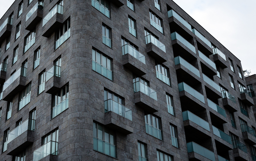

In [22]:
from PIL import Image
img = Image.open('img_001_SRF_2_LR.png')
img

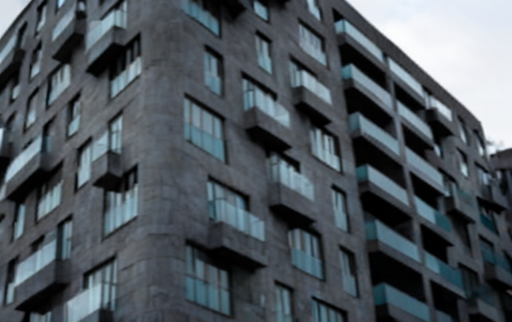

In [46]:
sr_img

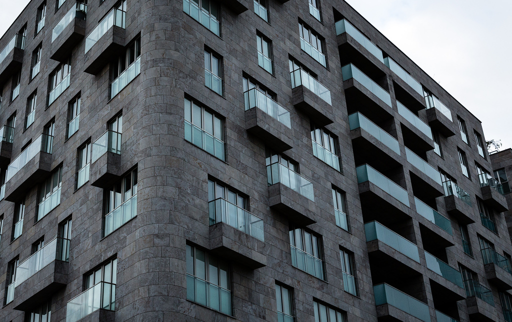

In [42]:
HR_img

In [41]:

from PIL import Image

# Load low-res image
LR_img = Image.open("img_001_SRF_2_LR.png")
HR_img = Image.open("img_001_SRF_2_HR.png")

# Run super-resolution
sr_img, psnr, ssim = super_resolve(var, vae, LR_img, HR_img, device=device)

# Save result
sr_img.save("superres_output_resized.png")

# Print metrics
print(f"PSNR: {psnr:.2f} dB")
print(f"SSIM: {ssim:.4f}")



PSNR: 23.05 dB
SSIM: 0.7095
